## Loading Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the CSV file into a pandas DataFrame
df = pd.read_csv('generated_data.csv')

# Separate features (X) and target variable (y)
X = df[['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5']]
y = df['Target']

# Print shapes to verify
print(f'Shape of X: {X.shape}, Shape of y: {y.shape}')

Shape of X: (506, 5), Shape of y: (506,)


## BackWard Propagation

The largest value representable by a numpy float is 1.7976931348623157e+308, whose logarithm is about 709.782, so the values are clipped to 709.

In [4]:
import numpy as np
np.finfo('d').max

1.7976931348623157e+308

### Forward Propagation

In [5]:
import numpy as np

def sigmoid(z):

    return (1/(1+np.exp(-z)))

def forward_propagation(X, y, w):

    n_samples, n_features = X.shape  # Number of samples and features

    ## Features
    feature_1 = X.iloc[:, 0] 
    feature_2 = X.iloc[:, 1]
    feature_3 = X.iloc[:, 2]
    feature_4 = X.iloc[:, 3]
    feature_5 = X.iloc[:, 4]

    ## PART - 1 Calculation
    cc = ((np.dot(feature_1,w[0]) + np.dot(feature_2,w[1]))**2)+w[5]  
    exp1 = np.clip(cc, -709, 709)
    exp = np.exp(exp1)

    ## PART - 2 Calculation
    tanh = np.tanh(exp + w[6])

    ## PART - 3  Calculation
    sig1 = np.dot(w[3],feature_4)+ np.dot(w[4],feature_5)
    sig = sigmoid((np.sin(np.dot(feature_3,w[2])) * sig1) + w[7])

    ## Final Calculation
    dy_pred = tanh + np.dot(w[8],sig)

    ## Mean Squared Loss Calculation
    loss = (dy_pred - y ) ** 2
    
    ## Dictionary output
    output = {"exp":exp,"tanh":tanh,"sig":sig,"loss":loss,"dy_pred":dy_pred}
    
    return output

### BackWard Propagation

In [6]:
def backward_propagation(X_train, y_train, W, dictionary):
    dW = {}

    ## Features
    feature_1 = X_train.iloc[:, 0]
    feature_2 = X_train.iloc[:, 1]
    feature_3 = X_train.iloc[:, 2]
    feature_4 = X_train.iloc[:, 3]
    feature_5 = X_train.iloc[:, 4]

    ## Loss
    L = dictionary['loss']

    dW[8] = 2 * np.sum(dictionary['sig'] * (dictionary['dy_pred'] - L)) # corrected

    dW[7] = 2 * np.sum(W[8]*dictionary['sig']* (1 - dictionary['sig']) * (dictionary['dy_pred'] - L)) # corrected

    dW[6] = 2 * np.sum((dictionary['dy_pred'] - L) * (1 - (np.tanh(dictionary['exp'] + W[6])))**2) ## corrected

    dW[5] = 2 * np.sum((dictionary['dy_pred'] - L) * (1 - (np.tanh(dictionary['exp'])**2)) * dictionary['exp']) ## corrected
    
    dW[4] = 2 * np.sum((dictionary['dy_pred'] - L) * np.dot(W[8], dictionary['sig'] * (1 - dictionary['sig'])) * np.sin(np.dot(feature_3,W[2])) * feature_5) ## corrected

    dW[3] = 2 * np.sum((dictionary['dy_pred'] - L) * np.dot(W[8], dictionary['sig'] * (1 - dictionary['sig'])) * np.sin(np.dot(feature_3,W[2])) * feature_4) ## corrected

    sig_dummy = np.dot(W[3],feature_4)+ np.dot(W[4],feature_5)
    dW[2] = 2 * np.sum((dictionary['dy_pred'] - L) * np.dot(W[8], dictionary['sig'] * (1 - dictionary['sig'])) * feature_3 * np.cos(np.dot(feature_3, W[2])) * sig_dummy) ## corrected

    cc_dummy = np.dot(feature_1,W[0]) + np.dot(feature_2,W[1])
    dW[1] = 2 * 2 * np.sum((dictionary['dy_pred'] - L) * feature_2 * (dictionary['exp'] * (1 - np.tanh(dictionary['exp'])**2)) * cc_dummy) ## corrected

    dW[0] = 2 * 2 * np.sum((dictionary['dy_pred'] - L) * feature_1 * (dictionary['exp'] * (1 - np.tanh(dictionary['exp'])**2)) * cc_dummy) ## corrected

    # Clip gradients if necessary
    for key, value in dW.items():
        dW[key] = np.clip(value, -709, 709)  # Example clipping range

    return dW

### Gradient Checking

In [9]:
def gradient_checking(W, X_train, y_train, dictionary, epsilon=1e-7):

    num_params = len(W)
    grad_approx = np.zeros(num_params)

    dictionary = forward_propagation(X_train, y_train, W)
    dW = backward_propagation(X_train, y_train, W, dictionary)

    dw = [x for x in dW.values()]

    for i in range(num_params):

        # Compute f(w1 + epsilon, w2, x1, x2)
        W_plus = np.copy(W)
        W_plus[i] = W[i] + epsilon
        fw_plus = forward_propagation(X_train, y_train, W_plus)
        loss_plus = fw_plus['loss']
        
        # Compute f(w1 - epsilon, w2, x1, x2)
        W_minus = np.copy(W)
        W_minus[i] = W[i] - epsilon
        fw_minus = forward_propagation(X_train, y_train, W_minus)
        loss_minus = fw_minus['loss']
        
        # Computing Approx numerical gradient
        grad_approx[i] =np.sum( (loss_plus - loss_minus) / (2 * epsilon))

    numerator = np.linalg.norm(dw - grad_approx)
    denominator = np.linalg.norm(dw) + np.linalg.norm(grad_approx)
    gradient_check = numerator / denominator
    
    return gradient_check, grad_approx, dW

In [10]:
epsilon = 1e-3 # Choose a small epsilon value

w=np.ones(9)*0.1

output= forward_propagation(X,y,w)
gradient_check, grad_approx, dW = gradient_checking(w, X, y, output)
print(f"Gradient check: {gradient_check}")

Gradient check: 0.6638546524215208


## Optimizers

### Vanilla Update of Weights

In [11]:
import numpy as np

def update_weights_vanilla(W, dW, learning_rate=0.01):
    W_updated = []
    for i in range(len(W)):
        W_updated.append(W[i] - learning_rate * dW[i])
    return W_updated

In [12]:
import decimal

w=np.ones(9)*0.1
decimal.getcontext().prec = 100

output= forward_propagation(X,y,w)
d1=backward_propagation(X,y,w,output)
W_updated = update_weights_vanilla(w, d1, learning_rate=0.01)
print("Updated weights:", W_updated)

Updated weights: [7.1899999999999995, 7.1899999999999995, 0.8807553885290951, 0.4768292378243624, 0.5052705892371092, 7.1899999999999995, 7.1899999999999995, 7.1899999999999995, 7.1899999999999995]


Epoch 10/100, Loss: 7.0129
Epoch 20/100, Loss: 7.1964
Epoch 30/100, Loss: 8.0059
Epoch 40/100, Loss: 8.0334
Epoch 50/100, Loss: 8.0548
Epoch 60/100, Loss: 8.1017
Epoch 70/100, Loss: 8.1201
Epoch 80/100, Loss: 8.1131
Epoch 90/100, Loss: 8.1404
Epoch 100/100, Loss: 8.1667


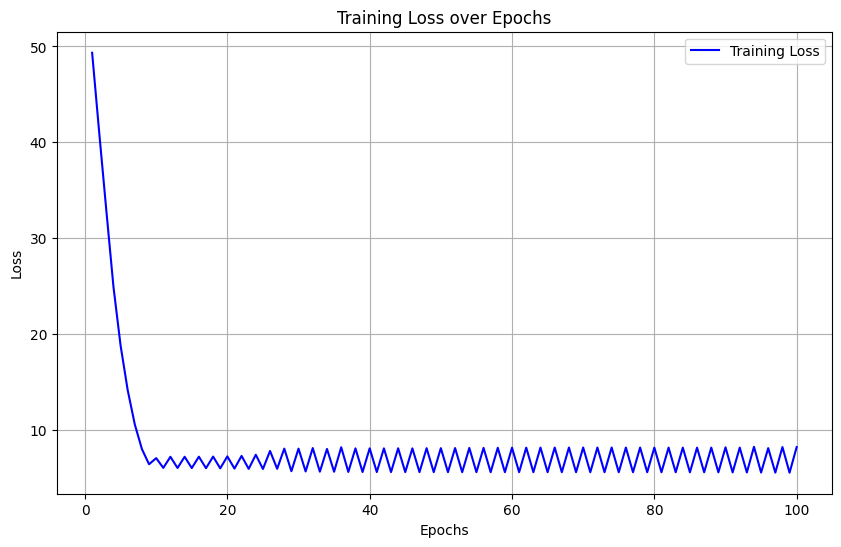

In [13]:
import numpy as np
import matplotlib.pyplot as plt

w=np.ones(9)*0.1
epochs = 100
learning_rate = 0.001
losses = []

for epoch in range(epochs):
    # Forward propagation
    output = forward_propagation(X, y, w)
    
    # Compute loss
    loss = np.mean(output['loss'])
    losses.append(loss)
    
    # Backward propagation
    gradients = backward_propagation(X, y, w, output)
    
    # Update weights using vanilla gradient descent
    w = update_weights_vanilla(w, gradients, learning_rate)
    
    
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
       
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Vanilla Update of Weights with momentum

In [14]:
def update_weights_momentum(W, dW, learning_rate=0.01, momentum=0.9, prev_dW=None):

    if prev_dW is None:
        prev_dW = {key: np.zeros_like(dW[key]) for key in dW.keys()}
    
    W_updated = []
    prev_dW_updated = {}
    
    for i, key in enumerate(dW.keys()):
        # Update momentum term
        prev_dW[key] = momentum * prev_dW[key] + (1 - momentum) * dW[key]
        
        # Update weights
        W_updated.append(W[i] - learning_rate * prev_dW[key])
        
        # Store updated previous gradients
        prev_dW_updated[key] = prev_dW[key]
    
    return W_updated, prev_dW_updated

In [15]:
import decimal

w=np.ones(9)*0.1
decimal.getcontext().prec = 100

output= forward_propagation(X,y,w)
d1=backward_propagation(X,y,w,output)
W_updated,_= update_weights_momentum(w, d1, learning_rate=0.01)


print("Updated weights:", W_updated)

Updated weights: [0.8089999999999997, 0.8089999999999997, 0.8089999999999997, 0.8089999999999997, 0.14052705892371092, 0.13768292378243624, 0.1780755388529095, 0.8089999999999997, 0.8089999999999997]


Epoch 10/100, Loss: 41.5024
Epoch 20/100, Loss: 39.5382
Epoch 30/100, Loss: 39.3905
Epoch 40/100, Loss: 39.2616
Epoch 50/100, Loss: 39.1529
Epoch 60/100, Loss: 39.0600
Epoch 70/100, Loss: 38.9799
Epoch 80/100, Loss: 38.9101
Epoch 90/100, Loss: 38.8487
Epoch 100/100, Loss: 38.7941


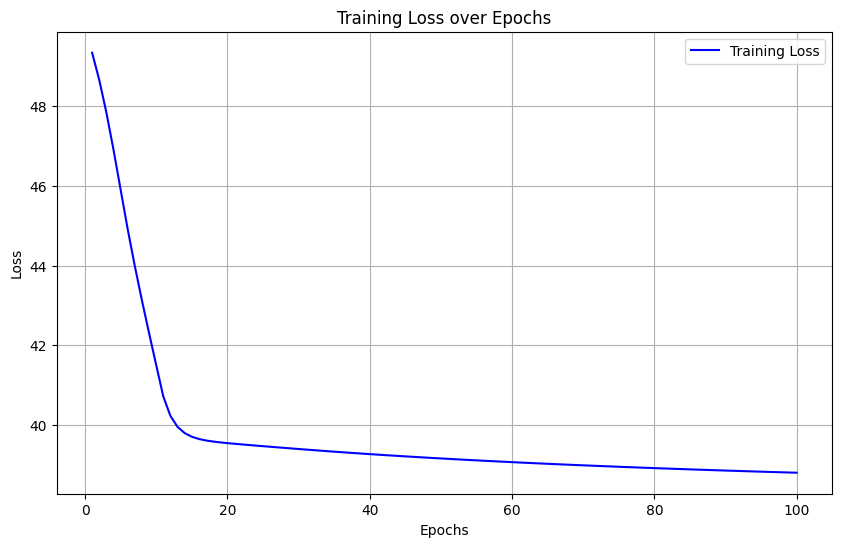

In [16]:
import numpy as np
import matplotlib.pyplot as plt

w=np.ones(9)*0.1

epochs = 100
learning_rate = 0.001
losses = []

for epoch in range(epochs):
    # Forward propagation
    output = forward_propagation(X, y, w)
    
    # Compute loss
    loss = np.mean(output['loss'])
    losses.append(loss)
    
    # Backward propagation
    gradients = backward_propagation(X, y, w, output)
    
    # Update weights using vanilla gradient descent with momentum
    w,_= update_weights_momentum(w, gradients, learning_rate)
   
    # Print progress
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Adam Update of Weights 

In [17]:
def update_weights_adam(W, dW, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, m=None, v=None, t=0):
    
    if m is None:
        m = {key: np.zeros_like(dW[key]) for key in dW.keys()}
    if v is None:
        v = {key: np.zeros_like(dW[key]) for key in dW.keys()}
    
    m_corrected = {}
    v_corrected = {}
    W_updated = []
    
    t = t + 1  # Update timestep
    
    for i, key in enumerate(dW.keys()):
        # Compute biased moment estimates
        m[key] = beta1 * m[key] + (1 - beta1) * dW[key]
        v[key] = beta2 * v[key] + (1 - beta2) * (dW[key] ** 2)
        
        # Correction bias in moment estimates
        m_corrected[key] = m[key] / (1 - beta1 ** t)
        v_corrected[key] = v[key] / (1 - beta2 ** t)
        
        # Update weights
        W_updated.append(W[i] - learning_rate * m_corrected[key] / (np.sqrt(v_corrected[key]) + epsilon))
    
    return W_updated, m, v

In [18]:
import decimal

w = np.ones(9)*0.1
decimal.getcontext().prec = 100
output= forward_propagation(X,y,w)
d1=backward_propagation(X,y,w,output)
W_updated ,_,_= update_weights_adam(w, d1, learning_rate=0.01)
print("Updated weights:", W_updated)

Updated weights: [0.10999999999985896, 0.10999999999985896, 0.10999999999985896, 0.10999999999985896, 0.10999999999753252, 0.10999999999734628, 0.10999999999871919, 0.10999999999985896, 0.10999999999985896]


Epoch 10/100, Loss: 49.1989
Epoch 20/100, Loss: 49.0343
Epoch 30/100, Loss: 48.8713
Epoch 40/100, Loss: 48.7100
Epoch 50/100, Loss: 48.5503
Epoch 60/100, Loss: 48.3923
Epoch 70/100, Loss: 48.2360
Epoch 80/100, Loss: 48.0814
Epoch 90/100, Loss: 47.9285
Epoch 100/100, Loss: 47.7774


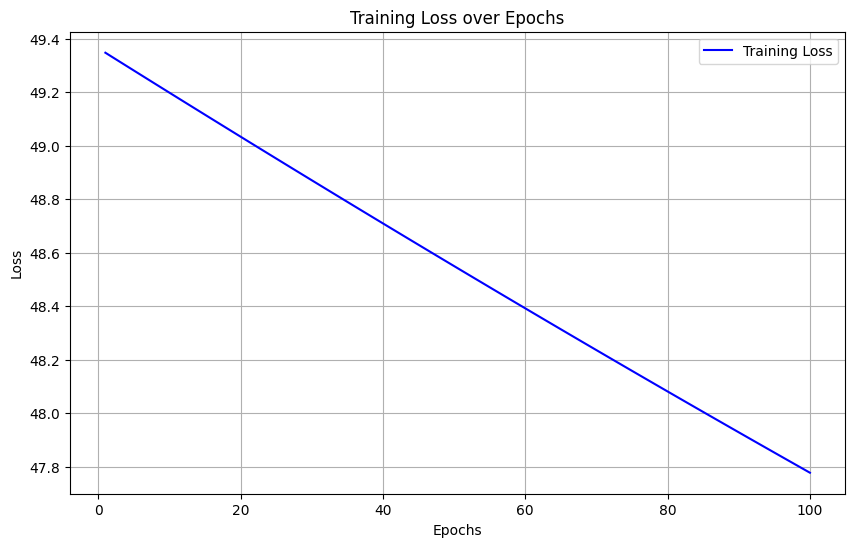

In [19]:
import numpy as np
import matplotlib.pyplot as plt

w = np.ones(9)*0.1

epochs = 100
learning_rate = 0.001
losses = []

for epoch in range(epochs):
    # Forward propagation
    output = forward_propagation(X, y, w)
    
    # Compute loss
    loss = np.mean(output['loss'])
    losses.append(loss)
    
    # Backward propagation
    gradients = backward_propagation(X, y, w, output)
    
    # Update weights using Adam Optimizer
    w,_,_= update_weights_adam(w, gradients, learning_rate)

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), losses, label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()